# Combine all dataset sources

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_data_dir = Path("../../data/raw")
processed_data_dir = Path("../../data/processed")
img_dir = Path("../../images")

## Parameters

In [3]:
START_DATE = "2016-04-15"
TIME_BIN = 7
MISSING_VALUES = ["Missing", "Invalid", "missing age", "Manquant", "Incertaine", "autre", "Uvira_UG_a_incertaine"]

## Import Data

### Raw Cholera Cases

In [4]:
df_chol = (
    pd.read_csv(
        raw_data_dir / "Histdata_with_results_oxford_23jan2025.csv",
        parse_dates=["dt_case_admission"]
    )
    .rename(
        columns = {
            "id_case": "id",
            "dt_case_admission": "date",
            "cat_case_quarter": "quarter",
            "cat_case_avenue": "avenue",
            "cat_rdt_o1": "rdt_result",
            "cat_culture": "culture_result"
        }
    )
    .replace(MISSING_VALUES, np.nan)
    .replace(["Hors_Uvira", "hors zone"], "Outside Uvira")
    .groupby(pd.Grouper(key = "date", freq = f"1D"), dropna=True)
    .agg(
        reports = ("id", "count"),
        rdt_confirmed = ("rdt_result", lambda x: (x == "Positive").sum())
    )
    .reset_index()
)

In [5]:
df_chol.head()

,date,reports,rdt_confirmed
0,2016-04-07,9,2
1,2016-04-08,11,3
2,2016-04-09,11,7
3,2016-04-10,12,6
4,2016-04-11,6,3


### Rainfall

In [6]:
df_rain = (
    pd.read_csv(
        raw_data_dir / "rainfall.csv",
        header = 1,
        names = ["date", "rainfall_mm"],
        parse_dates = ["date"]
    )
)

In [7]:
df_rain.head()

,date,rainfall_mm
0,2016-03-01,1.045609
1,2016-03-02,2.420091
2,2016-03-03,5.842659
3,2016-03-04,7.394491
4,2016-03-05,1.258014


### Surface Moisture

In [8]:
df_ssm = (
    pd.read_csv(
        raw_data_dir / "surface_soil_moisture.csv",
        header = 1,
        names = ["date", "ssm"],
        parse_dates = ["date"]
    )
)

In [9]:
df_ssm.head()

,date,ssm
0,2016-03-01,24.713062
1,2016-03-04,25.311626
2,2016-03-07,25.023958
3,2016-03-10,25.255598
4,2016-03-13,22.554688


### Sub Surface Moisture

In [10]:
df_subssm = (
    pd.read_csv(
        raw_data_dir / "sub_surface_soil_moisture.csv",
        header = 1,
        names = ["date", "subssm"],
        parse_dates = ["date"]
    )
)

In [11]:
df_subssm.head()

,date,subssm
0,2016-03-01,140.324158
1,2016-03-04,140.394974
2,2016-03-07,140.254745
3,2016-03-10,140.477356
4,2016-03-13,138.419647


### Evaporative Stress Index

In [12]:
df_esi = (
    pd.read_csv(
        raw_data_dir / "evaporative_stress_index.csv",
        header = 1,
        parse_dates = ["date"],
        na_values = ["-9999"],
        names = ["date", "esi"]
    )
)

In [13]:
df_esi.head()

,date,esi
0,2016-03-04,-0.500547
1,2016-03-11,-0.339754
2,2016-03-18,1.751842
3,2016-03-25,1.773401
4,2016-04-01,0.616665


<Axes: xlabel='date'>

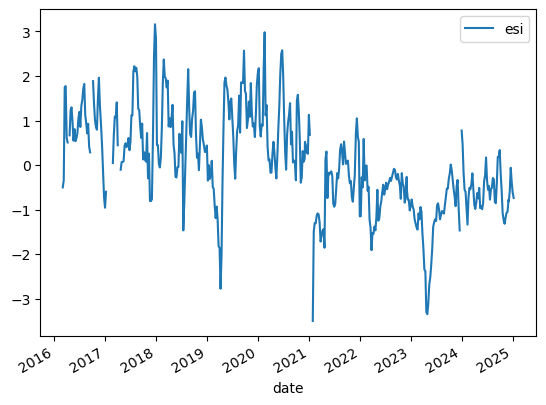

In [14]:
df_esi.set_index("date").plot()

### Tanganyika Level

In [15]:
df_lake = (
    pd.read_csv(
        raw_data_dir / "tanganyika_water_level.csv",
        header = 0,
        names = ["date", "lake_level"],
        parse_dates = ["date"],
    )
    .assign(
        date = lambda x: x["date"].dt.normalize()
    )
)

In [16]:
df_lake.head()

,date,lake_level
0,2016-03-06,771.580
1,2016-03-16,771.609
2,2016-04-05,771.607
3,2016-04-15,771.634
4,2016-04-25,771.449


### IDP - Conflicts - Disasters

In [17]:
df_idp_conflict_disaster = (
    pd.read_csv(
        processed_data_dir / "idp_conflict_disaster.csv",
        parse_dates = ["date"],
    )
)

### Vaccination Campaigns

In [35]:
df_vacc = pd.DataFrame(
    {
        "date": pd.to_datetime(["2020-07-29", "2020-09-28", "2023-07-26", "2023-09-25"]),
        "vacc_1": [1, 0, 1, 0],
        "vacc_1_prop": [0.5, 0, 0.5, 0],
        "vacc_2": [0, 1, 0, 1],
        "vacc_2_prop": [0, 0.25, 0, 0.25]
    }
)

In [36]:
df_vacc

,date,vacc_1,vacc_1_prop,vacc_2,vacc_2_prop
0,2020-07-29,1,0.5,0,0.00
1,2020-09-28,0,0.0,1,0.25
2,2023-07-26,1,0.5,0,0.00
3,2023-09-25,0,0.0,1,0.25


## Combine dataset

### Dates

In [34]:
df_dates_index = pd.date_range(
    # start = df_raw["date"].min(),
    start = START_DATE,
    # end = "2021-01-01",
    end = df_chol["date"].max(),
    freq = "D"
)
df_dates = (
    pd.DataFrame(
        df_dates_index,
        columns = ["date"]
    )
    .iloc[: len(df_dates_index) - (len(df_dates_index) % TIME_BIN), :]
)

### Daily reports

For now we focus on all suspected cases

In [37]:
df_inf = (
    df_dates
    .merge(
        df_chol,
        how = "left",
        on = "date"
    )
    .fillna(0)
)

### Combine all datasets

In [39]:
df = (
    df_inf
    .merge(
        df_vacc,
        on = "date",
        how = "left"
    )
    .merge(
        df_rain,
        on = "date",
        how = "left"
    )
    .merge(
        df_ssm,
        on = "date",
        how = "left"
    )
    .merge(
        df_subssm,
        on = "date",
        how = "left"
    )
    .merge(
        df_esi,
        on = "date",
        how = "left"
    )
    .merge(
        df_lake,
        on = "date",
        how = "left"
    )
    .merge(
        df_idp_conflict_disaster,
        on = "date",
        how = "left"
    )
    .assign(
        vacc_1 = lambda x: x["vacc_1"].fillna(0),
        vacc_1_prop = lambda x: x["vacc_1_prop"].fillna(0),
        vacc_2 = lambda x: x["vacc_2"].fillna(0),
        vacc_2_prop = lambda x: x["vacc_2_prop"].fillna(0),
        # rainfall_mm = lambda x: x["rainfall_mm"].fillna(0),
        # ssm = lambda x: x["ssm"].bfill(),
        # subssm = lambda x: x["subssm"].bfill(),
        # esi = lambda x: x["esi"].bfill(),
        # lake_level = lambda x: x["lake_level"].bfill(),
        # num_conflicts = lambda x: x["num_conflicts"].fillna(0),
        # num_fatalities = lambda x: x["num_fatalities"].fillna(0),
        rainfall_mm = lambda x: x["rainfall_mm"].fillna(0).where(
            (x["date"] > df_rain["date"].min()) & (x["date"] < df_rain["date"].max()),
            np.nan
        ),
        ssm = lambda x: x["ssm"].interpolate(limit_area = "inside"),
        subssm = lambda x: x["subssm"].interpolate(limit_area = "inside"),
        esi = lambda x: x["esi"].interpolate(limit_area = "inside"),
        lake_level = lambda x: x["lake_level"].interpolate(limit_area = "inside"),
        num_conflicts = lambda x: x["num_conflicts"].fillna(0).where(
            (x["date"] > df_idp_conflict_disaster["date"].min()) & (x["date"] < df_idp_conflict_disaster["date"].max()),
            np.nan
        ),
        num_fatalities = lambda x: x["num_fatalities"].fillna(0).where(
            (x["date"] > df_idp_conflict_disaster["date"].min()) & (x["date"] < df_idp_conflict_disaster["date"].max()),
            np.nan
        ),
        num_disasters = lambda x: x["num_disasters"].fillna(0).where(
            (x["date"] > df_idp_conflict_disaster["date"].min()) & (x["date"] < df_idp_conflict_disaster["date"].max()),
            np.nan
        ),
        num_disaster_affected = lambda x: x["num_disaster_affected"].fillna(0).where(
            (x["date"] > df_idp_conflict_disaster["date"].min()) & (x["date"] < df_idp_conflict_disaster["date"].max()),
            np.nan
        ),
    )
    .set_index("date")
)

In [41]:
df.columns

Index(['reports', 'rdt_confirmed', 'vacc_1', 'vacc_1_prop', 'vacc_2',
       'vacc_2_prop', 'rainfall_mm', 'ssm', 'subssm', 'esi', 'lake_level',
       'num_conflicts', 'num_fatalities', 'num_disasters',
       'num_disaster_affected', 'idps'],
      dtype='object')

### Save Data

In [42]:
df.to_csv(processed_data_dir / "uvira_full_data.csv", index=True)

## Visualizations

### Climate Data

In [23]:
clim_features_dict = {
    "rainfall_mm": "Rainfall",
    "ssm": "Surface Soil Moisture",
    "esi": "Evaporative Stress Index",
    "lake_level": "Tanganyika Lake Level"
}
labels = [
    "Depth (mm)",
    "Depth (mm)",
    "ET anomaly",
    "Water Level (m)"
]

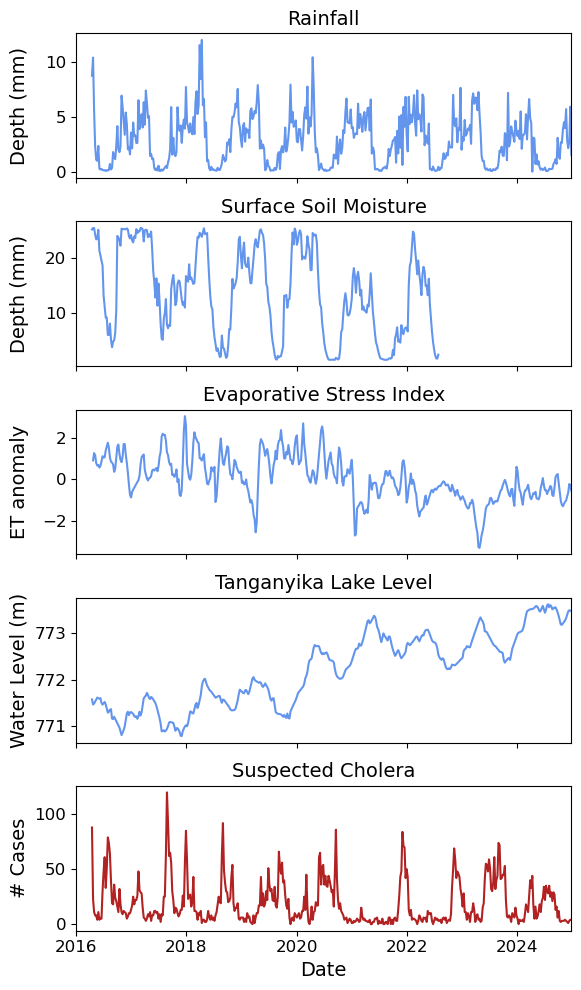

In [24]:
df_to_plot = (
    df
    .reset_index()
    .groupby(pd.Grouper(key = "date", freq = f"{TIME_BIN}D"), dropna=False)
    .agg({
        "reports": "sum",
        "rainfall_mm": "mean",
        "ssm": "mean",
        "esi": "mean",
        "lake_level": "mean",
    })
)

fig, axes = plt.subplots(
    nrows = len(clim_features_dict) + 1,
    ncols = 1,
    figsize = (6, (len(clim_features_dict) + 1) * 2),
    sharex = True
)

for i, (col, title) in enumerate(clim_features_dict.items()):
    (
        df_to_plot
        [col]
        .plot(
            ax = axes[i], 
            color = "cornflowerblue",
            legend = False,
        )
    )
    axes[i].set_title(title, fontsize = 14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel(labels[i], fontsize = 14)
    axes[i].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
    axes[i].tick_params(labelsize = 12)
(
    df_to_plot["reports"]
    .plot(
        ax = axes[-1],
        color = "firebrick",
        legend = False,
    )
)
axes[-1].set_title("Suspected Cholera", fontsize = 14)
axes[-1].set_xlabel("")
axes[-1].set_ylabel("# Cases", fontsize = 14)
axes[-1].tick_params(labelsize = 12)
axes[-1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
axes[-1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"]) 
axes[-1].set_xlabel("Date", fontsize = 14)
# plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()
plt.minorticks_off()
fig.align_ylabels()
plt.savefig(img_dir / "climate_data_timeseries.png", dpi = 300, bbox_inches = "tight")

### Humanitarian Data

In [25]:
df.head()

,reports,rdt_confirmed,rainfall_mm,ssm,subssm,esi,lake_level,num_conflicts,num_fatalities,num_disasters,num_disaster_affected,idps
date,,,,,,,,,,,,
2016-04-15,6,0,12.001953,24.716246,139.518494,NaN,771.6340,0.0,0.0,0.0,0.0,NaN
2016-04-16,24,0,11.792500,24.885131,139.597733,NaN,771.6155,0.0,0.0,0.0,0.0,NaN
2016-04-17,17,0,8.569291,25.054015,139.676971,NaN,771.5970,0.0,0.0,0.0,0.0,NaN
2016-04-18,17,0,3.274265,25.222900,139.756210,NaN,771.5785,0.0,0.0,0.0,0.0,NaN
2016-04-19,6,0,7.377607,25.281933,140.015559,NaN,771.5600,0.0,0.0,0.0,0.0,NaN


In [26]:
hum_features_dict = {
    "idps": "Internally Displaced Persons",
    "num_disaster_affected": "Affected by Disaster",
    "num_fatalities": "Conflict Fatalities",
}
labels = [
    "Counts",
    "Counts",
    "Counts"
]

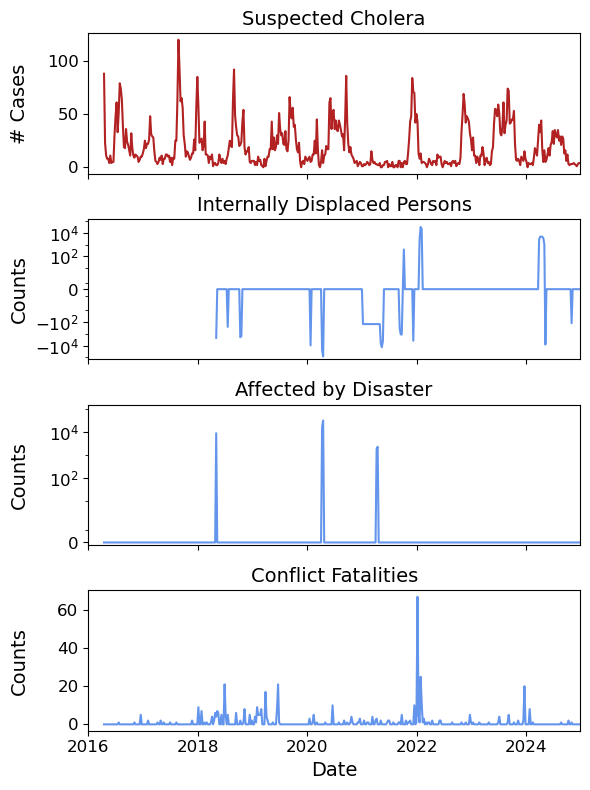

In [27]:
df_to_plot = (
    df
    .reset_index()
    .groupby(pd.Grouper(key = "date", freq = f"{TIME_BIN}D"), dropna=True)
    .agg({
        "reports": lambda x: x.sum() if not all(x.isna()) else np.nan,
        "num_fatalities": lambda x: x.sum() if not all(x.isna()) else np.nan,
        "num_disaster_affected": lambda x: x.sum() if not all(x.isna()) else np.nan,
        "idps": lambda x: x.sum() if not all(x.isna()) else np.nan,
    })
)

fig, axes = plt.subplots(
    nrows = len(hum_features_dict) + 1,
    ncols = 1,
    figsize = (6, (len(hum_features_dict) + 1) * 2),
    sharex = True
)

(
    df_to_plot["reports"]
    .plot(
        ax = axes[0],
        color = "firebrick",
        legend = False,
    )
)
axes[0].set_title("Suspected Cholera", fontsize = 14)
axes[0].set_xlabel("")
axes[0].set_ylabel("# Cases", fontsize = 14)
axes[0].tick_params(labelsize = 12)
axes[0].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])

for i, (col, title) in enumerate(hum_features_dict.items()):
    (
        df_to_plot
        [col]
        .plot(
            ax = axes[i+1], 
            color = "cornflowerblue",
            legend = False,
        )
    )
    axes[i+1].set_title(title, fontsize = 14)
    axes[i+1].set_xlabel("")
    axes[i+1].set_ylabel(labels[i], fontsize = 14)
    axes[i+1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
    axes[i+1].tick_params(labelsize = 12)


axes[2].set_yscale("symlog")
axes[2].set(yticks=[0, 100, 10000])
axes[2].set_ylim(-0.2, 150000)
axes[1].set_yscale("symlog")
axes[1].set(yticks=[-10000, -100, 0, 100, 10000])
axes[1].set_ylim(-150000, 150000)
# axes[i+1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
# axes[i+1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"]) 
axes[i+1].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
axes[i+1].set_xticklabels(["2016", "2018", "2020", "2022", "2024"]) 
axes[i+1].set_xlabel("Date", fontsize = 14)
# plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()
plt.minorticks_off()
fig.align_ylabels()
plt.savefig(img_dir / "humanitarian_data_timeseries.png", dpi = 300, bbox_inches = "tight")

In [28]:
df_to_plot.head()

,reports,num_fatalities,num_disaster_affected,idps
date,,,,
2016-04-15,88,0.0,0.0,NaN
2016-04-22,23,0.0,0.0,NaN
2016-04-29,11,0.0,0.0,NaN
2016-05-06,8,0.0,0.0,NaN
2016-05-13,8,0.0,0.0,NaN


In [29]:
features_dict = {
    # "reports": "Cholera",
    # "num_conflicts": "Conflicts",
    "num_fatalities": "# Fatalities",
    "rainfall_mm": "Rainfall",
    "ssm": "Surface Soil Moisture",
    # "subssm": "Sub-Surface Soil Moisture",
    "lake_level": "Tanganyika Lake Level"
}
labels = [
    # "# Cases",
    # "# Events",
    "# Deaths",
    "Depth (mm)",
    "Depth (mm)",
    # "Water Depth (mm)",
    "Water Level (m)"
]

In [30]:
df_to_plot = (
    df
    .reset_index()
    .groupby(pd.Grouper(key = "date", freq = f"{TIME_BIN}D"), dropna=False)
    .agg({
        "reports": "sum",
        "num_disasters": "sum",
        "num_disaster_affected": "sum",
        "num_conflicts": "sum",
        "num_fatalities": "sum",
        "rainfall_mm": "mean",
        "ssm": "mean",
        "subssm": "mean",
        "lake_level": "mean",
        "idps": "sum",
    })
)

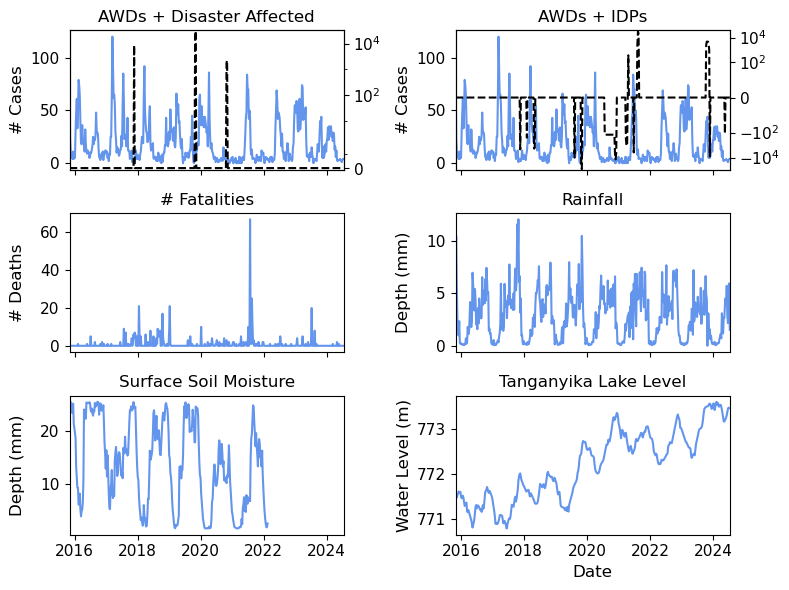

In [31]:
fig, axes = plt.subplots(
    nrows = int(len(features_dict) / 2) + 1,
    ncols = 2,
    figsize = (8, (int(len(features_dict) / 2) + 1) * 2),
    sharex = True
)
axes = axes.ravel()
(
    df_to_plot["reports"]
    .plot(
        ax = axes[0],
        color = "cornflowerblue",
        legend = False,
        title = "AWDs + Disaster Affected"
    )
)
ax02 = axes[0].twinx()
(
    df_to_plot["num_disaster_affected"]
    .plot(
        ax = ax02, 
        color = "black",
        linestyle = "--",
    )
)
# axes[0].vlines(
#     x = df_to_plot.loc[lambda x: x["disaster_affected"] > 0].index.values,
#     ymin = 0,
#     ymax = df_to_plot["reports"].max() + 5,
#     color = "black",
#     linestyle = "--",
#     label = "Disaster",
# )
axes[0].set_xlabel("")
axes[0].set_ylabel("# Cases", fontsize = 12)
axes[0].tick_params(labelsize = 11)
axes[0].set(xticks=["2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01", "2024-01-01"])
ax02.set_yscale("symlog")
ax02.set(yticks=[0, 100, 10000])
ax02.set_ylim(-0.1, None)
ax02.tick_params(labelsize = 11)
(
    df_to_plot["reports"]
    .plot(
        ax = axes[1],
        color = "cornflowerblue",
        legend = False,
        title = "AWDs + IDPs"
    )
)
ax12 = axes[1].twinx()
(
    df_to_plot["idps"]
    .plot(
        ax = ax12, 
        color = "black",
        linestyle = "--",
    )
)
axes[1].set_xlabel("")
axes[1].set_ylabel("# Cases", fontsize = 12)
axes[1].tick_params(labelsize = 11)
axes[1].set(xticks=["2016-06-15", "2018-06-15", "2020-06-15", "2022-06-15", "2024-06-15"])
ax12.set_yscale("symlog")
ax12.set(yticks=[-10000, -100, 0, 100, 10000])
ax12.tick_params(labelsize = 11)

for i, (col, title) in enumerate(features_dict.items()):
    (
        df_to_plot
        [col]
        .plot(
            ax = axes[i+2], 
            title = title,
            color = "cornflowerblue",
            legend = False,
        )
    )
    axes[i+2].set_xlabel("")
    axes[i+2].set_ylabel(labels[i], fontsize = 12)
    axes[i+2].set(xticks=["2016-06-15", "2018-06-15", "2020-06-15", "2022-06-15", "2024-06-15"])
    axes[i+2].tick_params(labelsize = 11)

axes[i+2].set(xticks=["2016-06-15", "2018-06-15", "2020-06-15", "2022-06-15", "2024-06-15"])
axes[i+2].set_xticklabels(["2016", "2018", "2020", "2022", "2024"]) 
axes[i+2].set_xlabel("Date", fontsize = 12)
# plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()
plt.minorticks_off()
fig.align_ylabels()